# Introduction

In [1]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from ipywidgets import interact, fixed
from libpysal import weights
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from sklearn.metrics import r2_score
from matplotlib.colors import LogNorm

## Sections and Research Questions

- POINTS DISTRIBUTION: What’s the nature of the distribution of Airbnb points in the Apulian region? Is there any structure we can statistically discern in the way locations are arranged over space?
- NEIGHBOURHOODS DISTRIBUTION: How are Airbnb distributed by neighbourhoods across Apulia?
- PRICE DISTRIBUTION: How is the price distributed across the region?
- Spatial autocorrelation of Airbnbs prices: do more expensive Airbnb tend to be geographically closer to each other?

In [2]:
abb = pd.read_csv('listings.csv')
# turning Airbnb dataframe into a geopandas dataframe
abb_gdf = gpd.GeoDataFrame({'geometry': gpd.points_from_xy(abb['longitude'], abb['latitude'])}, crs='EPSG:4326').join(abb)

In [3]:
neis = gpd.read_file("neighbourhoods.geojson").to_crs(epsg=3003)

In [4]:
# Create an interactive folium map - please refer to this map to look up the cities an areas are
m_1 = folium.Map(location=[40.7928, 17.1012], tiles='openstreetmap', zoom_start=10)

# Display the map
m_1

```
NOTE: To see this map, open the "apulia-folium-map" file in the "screenshot" folder.
```

# Points' Distribution
Research question: What’s the nature of the distribution of points? Is there any structure we can statistically discern in the way locations are arranged over space?

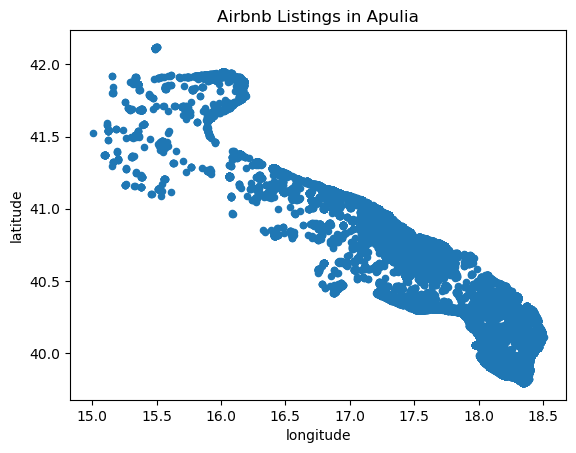

In [5]:
# Plot Airbnb locations in Apulia with a scatter plot
abb_gdf.plot.scatter('longitude', 'latitude')
plt.title('Airbnb Listings in Apulia')
plt.show()

Since there are many points, it is difficult to see any pattern in areas of high density. Let's plot a map with smaller, more translucent dots.

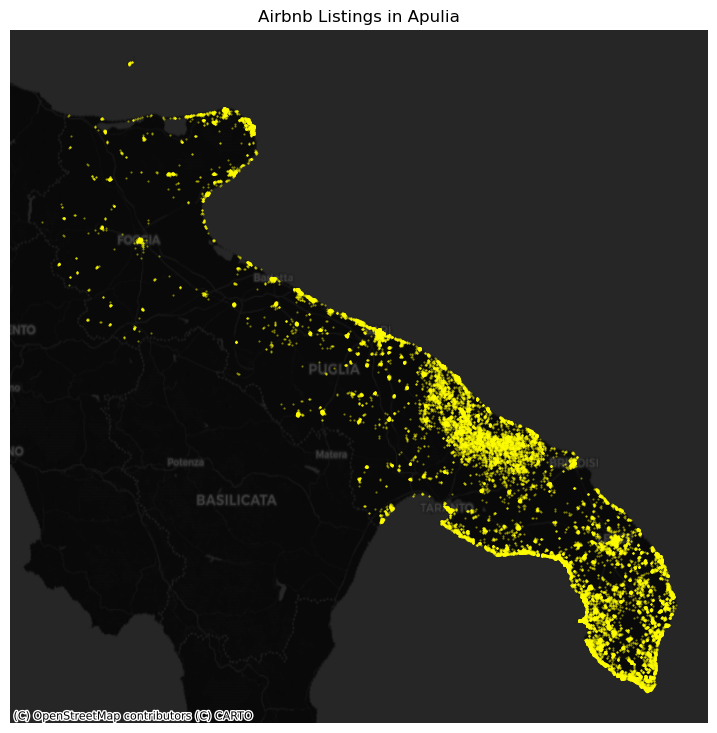

In [6]:
# Plot photographs with smaller, more translucent dots
ax = abb_gdf.plot.scatter(
    "longitude", 
    "latitude",
    s=0.25,
    c="xkcd:bright yellow",
    alpha=0.5,
    figsize=(9, 9)
)
# remove axis
ax.set_axis_off()
# Add dark basemap
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatter
)
plt.title('Airbnb Listings in Apulia')
plt.show()

The distribution now shows clear clustering around Valle d’Itria (a picturesque region just South of Bari) and the Salento coast (the southern end of the region), areas with high tourist activity. Outside these hotspots, listings are more dispersed, with very low presence in the Tavoliere plain, likely reflecting the lower population density and limited tourism appeal. This suggests a heterogeneous spatial distribution, structured by both tourism demand and population patterns.
Now let's go ahead and train a DBSCAN model to identify clusters of Airbnbs points, based on their density across space.

### DBSCAN

In [7]:
## Express points in metres
# Convert lon/lat points to Italian CRS in metres
abb_gdf = abb_gdf.to_crs(epsg=3003)
# Extract coordinates from point objects into columns
abb_gdf["X_metres"] = abb_gdf.geometry.x
abb_gdf["Y_metres"] = abb_gdf.geometry.y

In [8]:
# Set up algorithm - eps=radius, min_samples=min num of points
algo = DBSCAN(eps=1000, min_samples=300)

In [9]:
# Fit the model 
algo.fit(abb_gdf[["X_metres", "Y_metres"]])

,eps,1000
,min_samples,300
,metric,'euclidean'
,metric_params,None
,algorithm,'auto'
,leaf_size,30
,p,None
,n_jobs,None


In [10]:
# Print only the first five values
algo.core_sample_indices_[:5]

array([13, 16, 18, 23, 24])

In [11]:
# Turning labels into a series 
lbls = pd.Series(algo.labels_, index=abb_gdf.index)

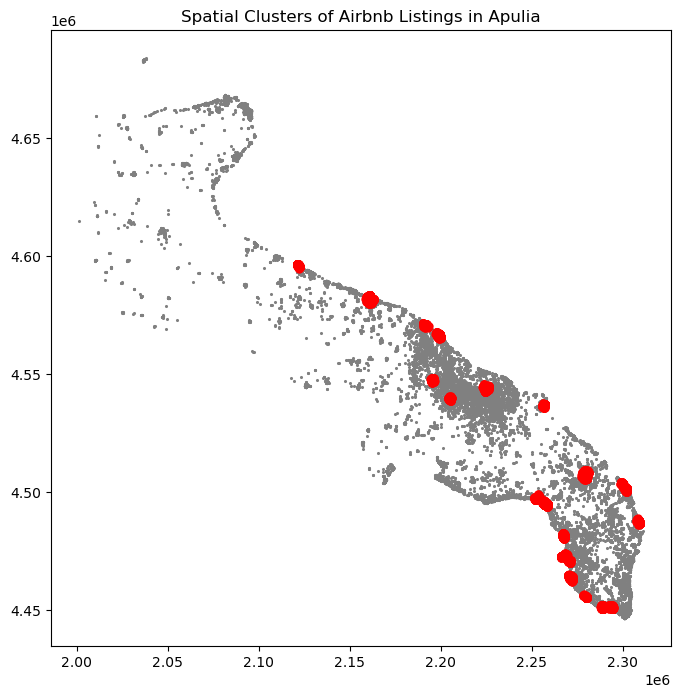

In [12]:
# Plot the DBSCAN output
f, ax = plt.subplots(1, figsize=(8,8))
noise = abb_gdf.assign(lbls=lbls).query("lbls == -1")
ax.scatter(noise["X_metres"], noise["Y_metres"], c='grey', s=5, linewidth=0)
ax.scatter(
    abb_gdf.loc[abb_gdf.index.difference(noise.index), "X_metres"], 
    abb_gdf.loc[abb_gdf.index.difference(noise.index), "Y_metres"],
    c="red", 
    linewidth=0
)
plt.title('Spatial Clusters of Airbnb Listings in Apulia')
plt.show()

Clusters with high density Airbnbs are along the coast of Apulia. This is where big cities like Barletta, Molfetta, and Bari are. Tourist destinations such as Polignano a Mare, Valle d'Itria, and Salento also have clusters.

We chose the eps and min_sample parameters specified above. This is because is important to show that the clusters are around the touristic area.

# Neighbourhoods Distribution

Research question: How are Airbnb distributed by neighbourhoods across Apulia?

In [13]:
# Getting only the airbnb points which interstect a neighbourhood polygon - via spatial join
joined_gdf = gpd.sjoin(abb_gdf, neis, how="inner")
joined_gdf.head()


,geometry,id,name,host_id,host_name,neighbourhood_group_left,neighbourhood_left,latitude,longitude,room_type,...,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,X_metres,Y_metres,index_right,neighbourhood_right,neighbourhood_group_right
0,POINT (2185803.442 4570947.273),37125,pietraviva una dimora nella natura,160280,Francesca,Bari,Conversano,41.00059,17.15027,Entire home/apt,...,0.01,1,365,0,IT072019C200095430,2.185803e+06,4.570947e+06,84,Conversano,Bari
1,POINT (2134635.298 4577485.921),45663,Luxury 10 Bedroom Villa with Pool,202935,Steven,Bari,Terlizzi,41.10029,16.55411,Private room,...,0.02,1,276,0,IT072043B500086352,2.134635e+06,4.577486e+06,122,Terlizzi,Bari
2,POINT (2212484.634 4541840.336),60925,I SETTE CONI - TRULLO LAVANDA,294274,Anna,Brindisi,Ostuni,40.71846,17.43095,Entire home/apt,...,0.66,3,54,7,IT074012B400027441,2.212485e+06,4.541840e+06,167,Ostuni,Brindisi
3,POINT (2077924.354 4662440.386),61987,Gargano Casa Vacanze con servizio colazione,301235,Giuseppe,Foggia,Vico del Gargano,41.90212,15.96531,Entire home/apt,...,0.32,7,359,4,IT071059B400023458,2.077924e+06,4.662440e+06,72,Vico del Gargano,Foggia
4,POINT (2077930.142 4662359.203),61989,Pizzicato BeB Gargano Monolocale Nocciola,301235,Giuseppe,Foggia,Vico del Gargano,41.90139,15.96530,Entire home/apt,...,0.18,7,365,0,IT071059B400023458,2.077930e+06,4.662359e+06,72,Vico del Gargano,Foggia


In [14]:
# Adding count of Airbnbs per neighbourhood in the neighbourhoood GeoDataFrame
airbnbs_by_neighbourhood = joined_gdf.groupby('neighbourhood_left').size()
neis = neis.join(pd.DataFrame({'airbnbs_count': airbnbs_by_neighbourhood}), on='neighbourhood') 

In [15]:
# Removing missing neighbourhoods
neis = neis[~neis["airbnbs_count"].isna()]

# Converting floats to int so that we can plot them
neis["airbnbs_count"] = neis["airbnbs_count"].astype(int)
neis.head()

,neighbourhood,neighbourhood_group,geometry,airbnbs_count
0,Triggiano,Bari,"MULTIPOLYGON (((2168996.138 4579637.959, 21704...",20
1,Taranto,Taranto,"MULTIPOLYGON (((2209230.772 4523185.17, 220945...",569
2,Rodi Garganico,Foggia,"MULTIPOLYGON (((2074812.674 4665607.391, 20748...",89
3,Alezio,Lecce,"MULTIPOLYGON (((2274010.673 4475223.256, 22749...",116
4,Brindisi,Brindisi,"MULTIPOLYGON (((2258575.962 4539860.549, 22585...",470


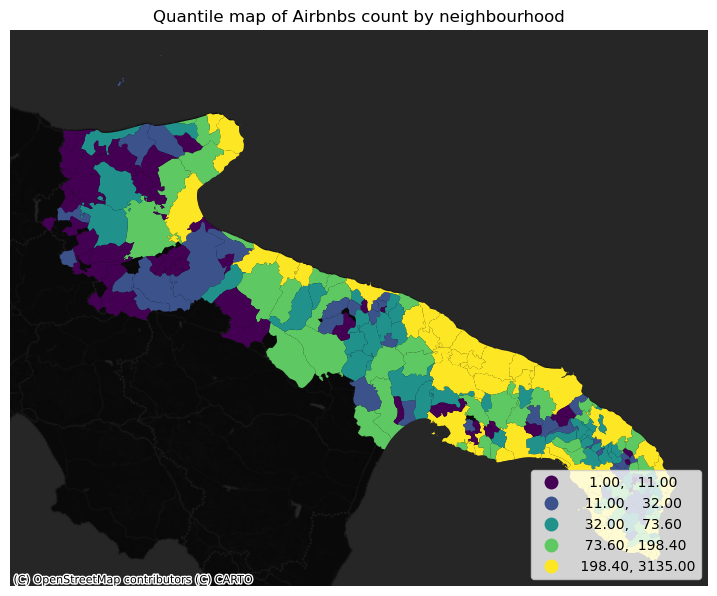

In [16]:
# Plotting the raw count of Airbnbs by neighbourhood
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot the equal interval choropleth and add a legend
neis.plot(
    column='airbnbs_count', 
    scheme='quantiles', 
    ax=ax,
    legend=True,
    legend_kwds={"loc": 4}
)
# Remove the axes
ax.set_axis_off()
# Set the title
ax.set_title("Quantile map of Airbnbs count by neighbourhood")
# Add dark basemap
cx.add_basemap(
    ax, 
    crs="EPSG:3003",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
# Draw map
plt.show()

- There is a high concentration of Airbnbs in the Valle d'Itria and the tip of the South of Salento
- The second highest concentration of Airbnbs seems to be under Bari (light green)
- Note that this map is showing the raw count of Airbnbs. This skews our final results, making it look as if some polygons have more data, simply because they have a larger area. To fix this, let's plot a map of the Airbnbs density.

In [17]:
# Calculating neighbourhoods' area in square kms - projecting data into a projected CRS that uses meres as units, not degrees
neis['area_sqkm'] = neis.to_crs(epsg=2459).area * 1e-6

# Calculating Airbnb density
neis['airbnb_density'] = neis['airbnbs_count'] / neis['area_sqkm']

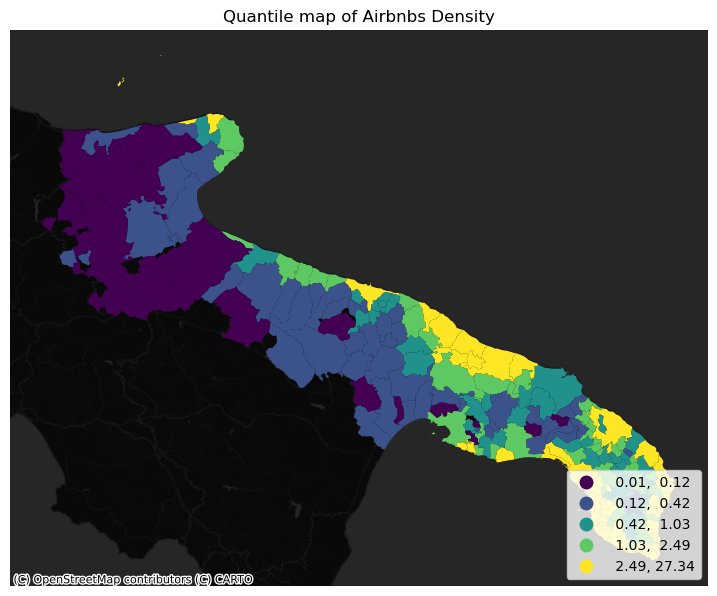

In [18]:
# Plotting the raw count of Airbnbs by neighbourhood
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot the equal interval choropleth and add a legend
neis.plot(
    column='airbnb_density', 
    scheme='quantiles', 
    ax=ax,
    legend=True,
    legend_kwds={"loc": 4}
)
# Remove the axes
ax.set_axis_off()
# Set the title
ax.set_title("Quantile map of Airbnbs Density")
# Add dark basemap
cx.add_basemap(
    ax, 
    crs="EPSG:3003",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
# Draw map
plt.show()

- Data points are now more accurately represented 
- Valle D'Itria and the South of Salento have a higher Airbnb density
- The area under Bari does not show as high of a density as it showed in the previous map (light purple)

# Price Distribution

Research question: How is the price distributed across the region?

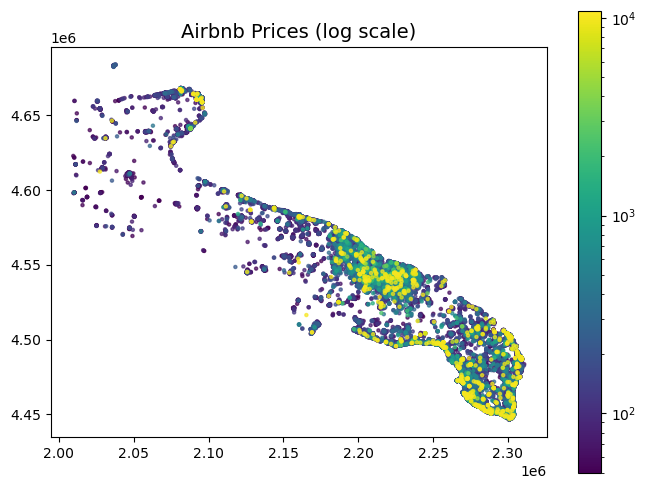

In [19]:
# Sort so higher-priced listings are plotted last (on top)
gdf = joined_gdf.sort_values("price")

# Plot
fig, ax = plt.subplots(figsize=(8,6))

gdf.plot(
    ax=ax,
    column="price",
    cmap="viridis",
    markersize=5,
    alpha=0.7,
    legend=True,
    norm=LogNorm(vmin=50, vmax=gdf["price"].max())  # <-- log scaling
)

ax.set_title("Airbnb Prices (log scale)", fontsize=14)
plt.show()

- Highest prices are clustered in the valle d'Itria and in the Southern coast, Salento.
- Cheaper prices are sparsed across the hinterland and the east side of the region.

# Spatial Autocorrelation


Research question: Is there evidence of spatial autocorrelation in Airbnb prices? For instance, do higher-priced listings tend to be located near other high-priced listings, while lower-priced ones are clustered together elsewhere?

In [20]:
# Set neighbourhood as index and keep it as a column
neis = neis.set_index('neighbourhood', drop=False)
neis.head()

,neighbourhood,neighbourhood_group,geometry,airbnbs_count,area_sqkm,airbnb_density
neighbourhood,,,,,,
Triggiano,Triggiano,Bari,"MULTIPOLYGON (((2168996.138 4579637.959, 21704...",20,38.845251,0.514863
Taranto,Taranto,Taranto,"MULTIPOLYGON (((2209230.772 4523185.17, 220945...",569,477.171669,1.192443
Rodi Garganico,Rodi Garganico,Foggia,"MULTIPOLYGON (((2074812.674 4665607.391, 20748...",89,24.334692,3.657330
Alezio,Alezio,Lecce,"MULTIPOLYGON (((2274010.673 4475223.256, 22749...",116,32.474486,3.572035
Brindisi,Brindisi,Brindisi,"MULTIPOLYGON (((2258575.962 4539860.549, 22585...",470,637.926950,0.736761


In [21]:
# Create spatial queen contiguity matrix
w = weights.Queen.from_dataframe(neis, ids='neighbourhood')

/opt/homebrew/anaconda3/envs/my_env/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: Isole Tremiti, San Marco la Catola.
  W.__init__(self, neighbors, ids=ids, **kw)


In [22]:
# Identify islands
w.islands

['Isole Tremiti', 'San Marco la Catola']

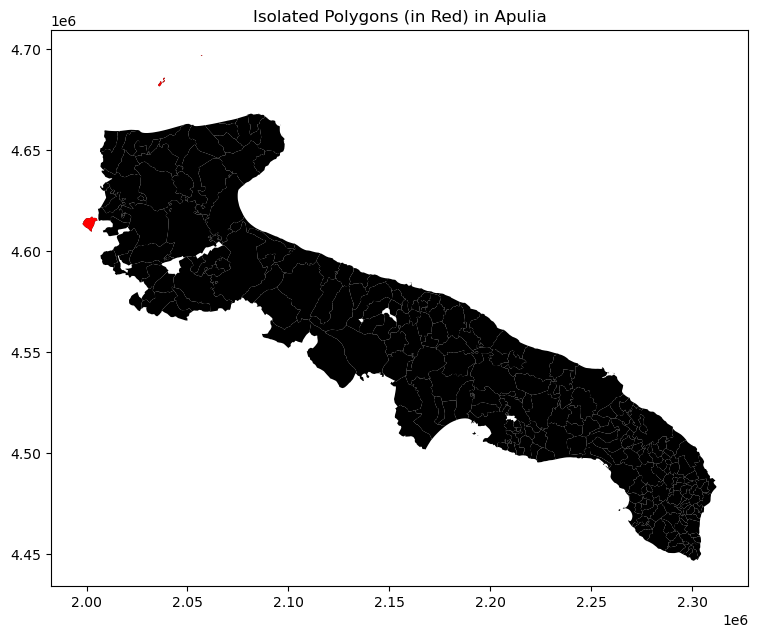

In [23]:
# Visualise islands
ax = neis.plot(color='k', figsize=(9,9))
neis.loc[w.islands, :].plot(color='red', ax=ax)
plt.title('Isolated Polygons (in Red) in Apulia')
plt.show()

- Isole Tremiti is an island and needs to be removed to avoid bias in our results.

In [24]:
# Removing Isole Tremiti from the neighbourhood geodataframe
neis = neis.drop(w.islands)

# Recreate spatial queen contiguity matrix without the island
w = weights.Queen.from_dataframe(neis, ids='neighbourhood')

In [25]:
# Row standardise the matrix to ensure every row sums up to one
w.transform = 'R'

# Reset and drop old neighbourhood index so that we can then merge the geodataframes
neis = neis.reset_index(drop=True)

# Calculate median Airbnb price for each neighbourhood
median_prices_df = abb_gdf.groupby('neighbourhood')['price'].median().reset_index()

# Merge median prices back into neighbourhood geodataframe
neis = neis.merge(median_prices_df, on='neighbourhood')

In [26]:
# Calculate the spatial lag of Airbnb prices
neis['w_price'] = weights.lag_spatial(w, neis['price'])

In [27]:
# Compare median Airbnb price per neighbourhood to its weighted version
neis[['neighbourhood', 'price', 'w_price']].sort_values(by=['w_price'], ascending=True)

,neighbourhood,price,w_price
15,Castelluccio Valmaggiore,50.0,44.250000
18,Faeto,55.0,47.000000
39,Roseto Valfortore,51.0,47.500000
40,Orsara di Puglia,50.0,48.833333
56,San Severo,70.0,50.285714
...,...,...,...
19,Ascoli Satriano,52.0,NaN
29,Cerignola,66.0,NaN
51,Stornarella,65.0,NaN
62,Stornara,50.0,NaN


- The neighbourhood with the highest weighted price is Torre Santa Susanna, probably explained by its location in Salento.
- The neighbourhood with the lowest weighted price is Castelluccio Valmaggiore, probably explained by its north-western, less touristic location.

In [28]:
# Standardise median prices 
neis['price_standardised'] = (neis['price'] - neis['price'].mean()) / neis['price'].std()

<Axes: ylabel='Frequency'>

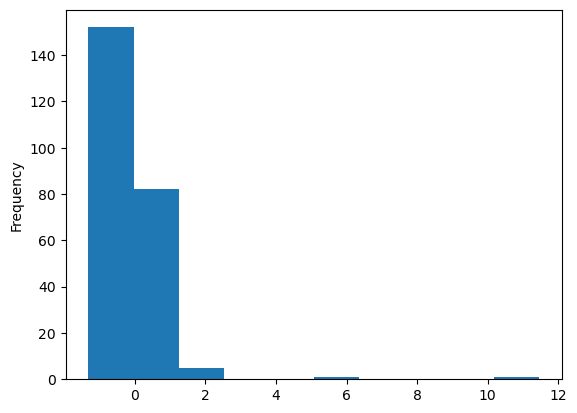

In [29]:
neis['price_standardised'].plot.hist()

In [30]:
# Remove outliers
masked_neis = neis[neis['price_standardised']<5]

In [31]:
# Recreate spatial queen contiguity matrix without the island
w = weights.Queen.from_dataframe(masked_neis, ids='neighbourhood')

In [32]:
# Recalculate spatial lag
masked_neis['w_price_standardised'] = weights.lag_spatial(w, masked_neis['price_standardised'])

/opt/homebrew/anaconda3/envs/my_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


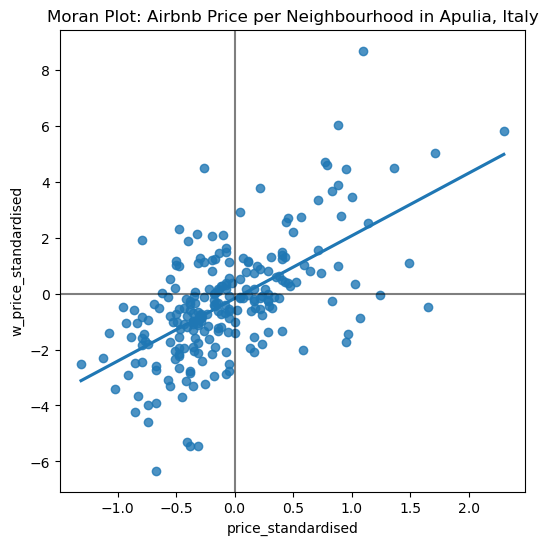

In [33]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(
    x="price_standardised",
    y="w_price_standardised",
    data=masked_neis,
    ci=None,
)
# Add vertical and horizontal lines
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add title
plt.title("Moran Plot: Airbnb Price per Neighbourhood in Apulia, Italy")
# Display
plt.show()

- There is a positive spatial autocorrelation with Airbnb's median prices across neighbourhoods in Apulia.

In [34]:
# Calculate pearson_1 for Airbnb median price per neighbourhood
from scipy.stats import pearsonr
pearson_1 = pearsonr(
    masked_neis["price_standardised"],
    masked_neis["w_price_standardised"],
)
print(f"The pearson_1 is {pearson_1.statistic}")

The pearson_1 is 0.6030895134688539


- The Pearson coefficient confirms that there is a positive relationship. 
- If a neighbourhood has a high median Airbnb price, its neighbourhoods will also have a high median price.